In [2]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv('Hurto_a_personas_2017.csv')
df.head()

,Fecha,Departamento,Municipio,Día,Hora,Barrio,Zona,Clase de sitio,Arma empleada,Móvil Agresor,Móvil Victima,Edad,Sexo,Estado civil,País de nacimiento,Clase de empleado,Profesión,Escolaridad,Código DANE,Cantidad
0,01/01/2017 12:00:00 AM,ANTIOQUIA,MEDELLÍN (CT),Domingo,12/31/1899 12:00:00 AM,LAURELES C-11,URBANA,VIAS PUBLICAS,CONTUNDENTES,A PIE,A PIE,62,MASCULINO,SOLTERO,COLOMBIA,INDEPENDIENTE,INGENIERO,SUPERIOR,5001000,1
1,01/01/2017 12:00:00 AM,ANTIOQUIA,MEDELLÍN (CT),Domingo,12/31/1899 12:00:00 AM,MORAVIA C-4,URBANA,VIAS PUBLICAS,CONTUNDENTES,A PIE,A PIE,53,FEMENINO,SOLTERO,COLOMBIA,EMPLEADO PARTICULAR,-,SECUNDARIA,5001000,1
2,01/01/2017 12:00:00 AM,ANTIOQUIA,MEDELLÍN (CT),Domingo,12/31/1899 10:00:00 AM,LA CANDELARIA C-10,URBANA,VIAS PUBLICAS,ARMA BLANCA / CORTOPUNZANTE,A PIE,A PIE,39,MASCULINO,UNION LIBRE,COLOMBIA,EMPLEADO PARTICULAR,-,SECUNDARIA,5001000,1
3,01/01/2017 12:00:00 AM,ANTIOQUIA,MEDELLÍN (CT),Domingo,12/31/1899 10:00:00 AM,LA CANDELARIA C-10,URBANA,VIAS PUBLICAS,ARMA BLANCA / CORTOPUNZANTE,A PIE,A PIE,43,MASCULINO,UNION LIBRE,COLOMBIA,EMPLEADO PARTICULAR,-,PRIMARIA,5001000,1
4,01/01/2017 12:00:00 AM,ANTIOQUIA,MEDELLÍN (CT),Domingo,12/31/1899 03:00:00 PM,LA CANDELARIA C-10,URBANA,VIAS PUBLICAS,ARMA BLANCA / CORTOPUNZANTE,A PIE,A PIE,26,FEMENINO,SOLTERO,COLOMBIA,EMPLEADO PARTICULAR,-,SECUNDARIA,5001000,1


In [5]:
bogota = df[df['Municipio'].str.contains('BOGOTÁ')]

In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize
import matplotlib.cm
%matplotlib inline

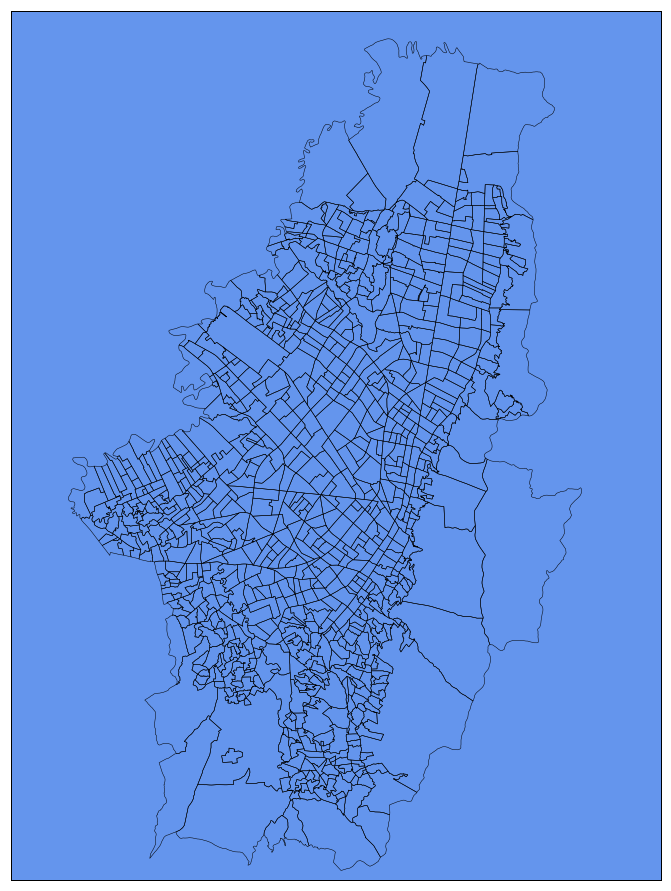

In [53]:
fig, ax = plt.subplots(figsize=(16, 16))

m = Basemap(projection='merc',
            llcrnrlat=4.45,
            llcrnrlon=-74.25,
            urcrnrlat=4.85,
            urcrnrlon=-73.95,
            resolution = 'c',
            ax=ax)

m.drawmapboundary(fill_color='aqua')
m.fillcontinents(color='#6495ed',lake_color='aqua')
m.drawcoastlines()
m.readshapefile('./barrios_catastrales/barrios_catastrales_2', 'barrios');

In [57]:
crime_neighborhood = bogota['Barrio'].value_counts()
crime_neighborhood = crime_neighborhood.reset_index()
crime_neighborhood.columns = ['Barrio', 'Cantidad de Hurtos']

In [92]:
crime_neighborhood.head()

,Barrio,Cantidad de Hurtos
0,CHAPINERO CENTRAL,1123
1,TEUSAQUILLO,670
2,PATIO BONITO,641
3,BELLA SUIZA,530
4,CHAPINERO ALTO E-2,490


In [65]:
df_poly = pd.DataFrame({'Forma': [Polygon(np.array(shape), True) for shape in m.barrios],
                        'Barrio': [area['NOMB_BARR'] for area in m.barrios_info]})

In [68]:
for i, row in df_poly.iterrows():
    crime_neighborhood.loc[crime_neighborhood['Barrio'].str.lower().str.contains(row['Barrio'].lower()), 'Barrio'] = row['Barrio']

c:\python\python36\lib\site-packages\ipykernel\__main__.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  from ipykernel import kernelapp as app


In [70]:
df_poly = pd.merge(df_poly, crime_neighborhood, left_on='Barrio', right_on='Barrio', how='left')

In [72]:
df_poly.fillna(0, inplace=True)

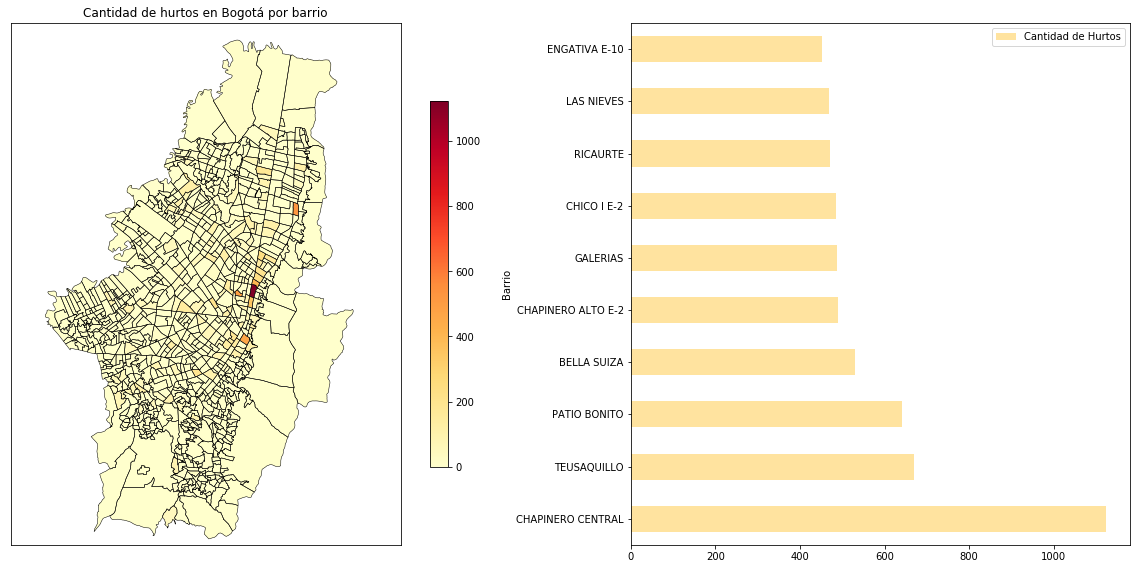

In [104]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

m = Basemap(projection='merc',
            llcrnrlat=4.45,
            llcrnrlon=-74.25,
            urcrnrlat=4.85,
            urcrnrlon=-73.95,
            resolution = 'c',
            ax=ax[0])

cmap = plt.get_cmap('YlOrRd')   
pc = PatchCollection(df_poly['Forma'], zorder=2)
norm = Normalize()
 
pc.set_facecolor(cmap(norm(df_poly['Cantidad de Hurtos'].fillna(0).values)))
ax[0].add_collection(pc)

mapper = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
 
mapper.set_array(df_poly['Cantidad de Hurtos'])
fig.colorbar(mapper, ax=ax[0], shrink=0.7)

m.readshapefile('./barrios_catastrales/barrios_catastrales_2', 'barrios')

ax[0].set_title('Cantidad de hurtos en Bogotá por barrio')

crime_neighborhood.set_index('Barrio').head(10).plot.barh(ax=ax[1], color='#ffe39f')
fig.tight_layout()